#### Universidade Federal de Santa Catarina
#### Programa de Pós-Graduação em Engenharia Elétrica
#### Modelagem Dinâmica de Conversores Estáticos

## Resolução da Tarefa 4

Data: 11/06/2022

Discente: Eduardo Eller Behr

![enunciado](enunciado-T4.png)

In [45]:
from matplotlib import pyplot as plt
import control as ctl
import numpy as np
import sympy as sp

### I) Função de Transferência $\frac{v_o(s)}{d(s)}$ (**sem** perdas)


In [46]:
iL1, iL2, vC1, vC2 = sp.symbols("i_{L1} i_{L2} v_{C1} v_{C2}")
d, vi, s = sp.symbols("d v_i s")
R, L1, L2, C1, C2 = sp.symbols("R L_1 L_2 C_1 C_2")

U = sp.Matrix([
    [vi]
])

# Considerando que vo = 1*vC2
C = sp.Matrix([[0, 0, 0, 1]])

# display('X=', X); 
display('U=', U); display('C=', C)

'U='

Matrix([[v_i]])

'C='

Matrix([[0, 0, 0, 1]])

#### a) 1ª etapa de operação
![etapa 1](etapa-1-ideal.png)

In [47]:
A1 = sp.Matrix([
	[0,		0,		0,		0			], # iL1
	[0,		0,		1/L2,	0			], # iL2
	[0,		-1/C1,	0,		0			], # vC1
	[0,		0,		0,		-1/(R*C2)	], # vC2
#    L1		L2		C1		C2
])

B1 = sp.Matrix([
	[1/L1	], # iL1
	[0		],    # iL2
	[0		],    # vC1
	[0		],    # vC2
])

display('A1=', A1)
display('B1=', B1)


'A1='

Matrix([
[0,      0,     0,          0],
[0,      0, 1/L_2,          0],
[0, -1/C_1,     0,          0],
[0,      0,     0, -1/(C_2*R)]])

'B1='

Matrix([
[1/L_1],
[    0],
[    0],
[    0]])

#### b) 2ª Etapa de operação
![etapa 2](etapa-2-ideal.png)

In [48]:
A2 = sp.Matrix([
	[0,		0,		-1/L1,  0			], # iL1
	[0,		0,		1/L2,	-1/L2		], # iL2
	[1/C1,	-1/C1,	0,		0			], # vC1
	[0,		1/C2,	0,		-1/(R*C2)	], # vC2
#    L1		L2		C1		C2
])

B2 = sp.Matrix([
	[1/L1	],      # iL1
	[0		],      # iL2
	[0		],      # vC1
	[0		],      # vC2
])

display('A2=', A2)
display('B2=', B2)

'A2='

Matrix([
[    0,      0, -1/L_1,          0],
[    0,      0,  1/L_2,     -1/L_2],
[1/C_1, -1/C_1,      0,          0],
[    0,  1/C_2,      0, -1/(C_2*R)]])

'B2='

Matrix([
[1/L_1],
[    0],
[    0],
[    0]])

#### c) Média das duas etapas

O ponto de operação em regime permanente é dado por:

![regime](solucao-regime.png)

A função de transferencia é obtida com:

![formula-tf](formula-ss-tf.png)

In [49]:
A = d*A1 + (1-d)*A2
B = d*B1 + (1-d)*B2
X = -A**-1*B*U

G = C*((s*sp.eye(4)-A)**-1)*( (A1-A2)*X + (B1-B2)*U )

In [50]:
display('Gvd=', G[0].factor(s))

'Gvd='

v_i*(-d**7 + 7*d**6 - 21*d**5 + 35*d**4 - 35*d**3 + 21*d**2 - 7*d + 1)*(C_1*L_1*L_2*s**3 - 2*R*d**4 + 8*R*d**3 - 12*R*d**2 + 8*R*d - 2*R + s**2*(-C_1*L_1*R*d**2 + 2*C_1*L_1*R*d - C_1*L_1*R) + s*(2*L_1 + L_2*d**2 - 2*L_2*d + L_2))/((1 - d)*(d**2 - 2*d + 1)*(d**3 - 3*d**2 + 3*d - 1)*(d**4 - 4*d**3 + 6*d**2 - 4*d + 1)*(C_1*C_2*L_1*L_2*R*s**4 + C_1*L_1*L_2*s**3 + R*d**4 - 4*R*d**3 + 6*R*d**2 - 4*R*d + R + s**2*(C_1*L_1*R*d**2 - 2*C_1*L_1*R*d + C_1*L_1*R + C_2*L_1*R + C_2*L_2*R*d**2 - 2*C_2*L_2*R*d + C_2*L_2*R) + s*(L_1 + L_2*d**2 - 2*L_2*d + L_2)))

Substituindo os valores numéricos

In [51]:
params = {
    L1: 1000e-6,
    L2: 100e-6,
    C1: 2e-6,
    C2: 20e-6,
    R:  50,
    d: 0.55,
    vi: 48
}

Gvd = G.subs(params)

Gvd = Gvd[0].factor(s).simplify()

display('Gvd=',Gvd.evalf(3)); display('X=', X.subs(params).evalf(6))

'Gvd='

(-5.14e-11*s**3 + 5.2e-6*s**2 - 0.519*s + 1.05e+3)/(9.76e-17*s**4 + 9.75e-14*s**3 + 5.07e-7*s**2 + 0.000498*s + 1.0)

'X='

Matrix([
[23.4111],
[ 10.535],
[106.667],
[237.037]])

Convertendo para objeto TransferFunction

In [52]:
def sympy_rational_to_control_tf(rational):
    numerator, denominator = rational.as_numer_denom()
    num, den = sp.Poly(numerator).all_coeffs(), sp.Poly(denominator).all_coeffs()

    for i, _n in enumerate(num):
        num[i] = float(num[i])

    for i, _d in enumerate(den):
        den[i] = float(den[i])

    return ctl.TransferFunction(num, den)

Gvd_tf = sympy_rational_to_control_tf(Gvd)
Gvd_tf

TransferFunction(array([-5.13823109e-11,  5.20245897e-06, -5.19025568e-01,  1.05349794e+03]), array([9.75461058e-17, 9.75461058e-14, 5.07483615e-07, 4.97607072e-04,
       1.00000000e+00]))

### II) Função de Transferência $\frac{v_o(s)}{d(s)}$ (**com** perdas)

In [53]:
Vd, RL1, RL2, Ron, RC1, RC2 = sp.symbols('V_d R_{L1} R_{L2} R_{on} R_{C1} R_{C2}')

Up = sp.Matrix([
    vi,
    Vd
])

display('Up=', Up)

'Up='

Matrix([
[v_i],
[V_d]])

#### a) 1ª Etapa de operação

![etapa 1 perdas](etapa-1-perdas.png)

In [54]:
A1p = sp.Matrix([
	[-(RL1+Ron)/L1,	0,				0,				0				], # iL1
	[-Ron/L2,		-(RC1+RL2+Ron)/L2,	1/L2,		0				], # iL2
	[0,				-1/C1,			0,				0				], # vC1
	[0,				0,				0,				-1/((RC2+R)*C2)	], # vC2
#    L1				L2				C1				C2
])

# entradas:  vi e vd
B1p = sp.Matrix([
	[1/L1,	-1/L1	],	# iL1
	[0,		0		],	# iL2
	[0,		0		],	# vC1
	[0,		0		],	# vC2
#	vi		vd
])

display('A1p=', A1p)
display('B1p=', B1p)


'A1p='

Matrix([
[(-R_{L1} - R_{on})/L_1,                               0,     0,                     0],
[           -R_{on}/L_2, (-R_{C1} - R_{L2} - R_{on})/L_2, 1/L_2,                     0],
[                     0,                          -1/C_1,     0,                     0],
[                     0,                               0,     0, -1/(C_2*(R + R_{C2}))]])

'B1p='

Matrix([
[1/L_1, -1/L_1],
[    0,      0],
[    0,      0],
[    0,      0]])

#### b) 2ª Etapa de operação

![etapa-2-perdas](etapa-2-perdas.png)

In [55]:
# vo=(vC2+RC2*iL2)/(1-RC2/R)
# iC2 = (iL2*(R - 2*RC2) - vC2)/(R - RC2)
# dvC2/dt = (iL2*(R - 2*RC2)/C2 - vC2/C2)/(R - RC2)
# dvC2/dt = iL2*(R - 2*RC2)/(C2(R - RC2))   - vC2)/(C2(R - RC2))  

A2p = sp.Matrix([
	[-(RL1+RC1)/L1,		RC1/L1,						-1/L1,  	0					], # iL1
	[RC1/L2,			-(RC1+RL2)/L2,				1/L2,		-1/L2				], # iL2
	[1/C1,				-1/C1,						0,			0					], # vC1
	[0,					(R - 2*RC2)/(C2*(R - RC2)),	0,			-1/(C2*(R - RC2))	], # vC2
#    L1					L2				C1			C2
])

B2p = sp.Matrix([
	[1/L1,	-1/L1	],	# iL1
	[0,		-1/L2	],	# iL2
	[0,		0		],	# vC1
	[0,		0		],	# vC2
])

display('A2p=', A2p)
display('B2p=', B2p)




'A2p='

Matrix([
[(-R_{C1} - R_{L1})/L_1,                        R_{C1}/L_1, -1/L_1,                     0],
[            R_{C1}/L_2,            (-R_{C1} - R_{L2})/L_2,  1/L_2,                -1/L_2],
[                 1/C_1,                            -1/C_1,      0,                     0],
[                     0, (R - 2*R_{C2})/(C_2*(R - R_{C2})),      0, -1/(C_2*(R - R_{C2}))]])

'B2p='

Matrix([
[1/L_1, -1/L_1],
[    0, -1/L_2],
[    0,      0],
[    0,      0]])

Definindo valores das variáveis de perdas

In [56]:
params.update({
	RL1: 1, 
	RL2: 0.1, 
	RC1: 0.01, 
	RC2: 0.1, 
	Vd: 1,
	Ron: 0.05
});

#### c) Média das duas etapas

In [57]:
Ap = (d*A1p + (1-d)*A2p).subs(params)
Bp = (d*B1p + (1-d)*B2p).subs(params)
Xp = -Ap**-1*Bp*Up.subs(params)

# Obs: vo=(vC2 + RC2*iL2)/(1-RC2/R)
Cp = sp.Matrix([
    [0,     RC2/(1-RC2/R),      0,      1/(1-RC2/R)]
]).subs(params)

Gvdp = (Cp*((s*sp.eye(4)-Ap)**-1)*( (A1p-A2p).subs(params)*Xp + (B1p-B2p).subs(params)*Up.subs(params) ))[0]
Gvdp = Gvdp.factor(s).simplify()
display('Gvdp=', Gvdp.evalf(3))

Gvdp_tf = sympy_rational_to_control_tf(Gvdp)

'Gvdp='

(-7.65e-28*s**7 + 1.06e-22*s**6 - 1.75e-17*s**5 + 5.22e-13*s**4 - 7.1e-8*s**3 - 7.06e-5*s**2 - 0.0662*s + 221.0)/(6.42e-17*s**4 + 2.19e-13*s**3 + 3.34e-7*s**2 + 0.000677*s + 1.0)**2

### Comparação entre modelos com e sem perdas

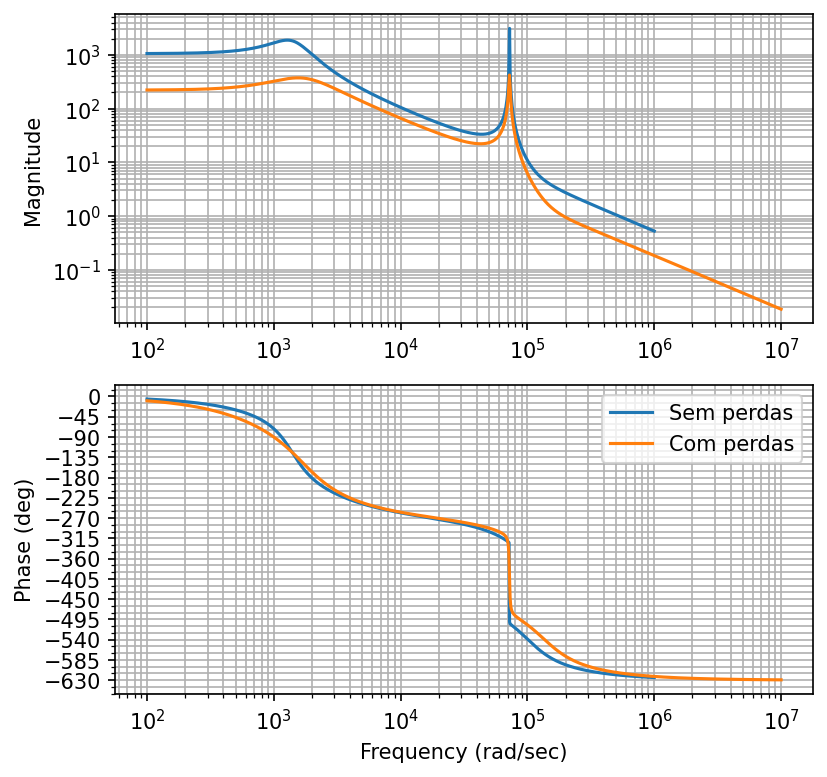

In [58]:
plt.figure(dpi=150, figsize=(6,6))
ctl.bode(Gvd_tf);
ctl.bode(Gvdp_tf);
plt.legend(["Sem perdas", "Com perdas"]);

/home/eduardo/.local/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=6.09441e-21): result may not be accurate.
  return solve(Q, P)
/home/eduardo/.local/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=1.78027e-49): result may not be accurate.
  return solve(Q, P)


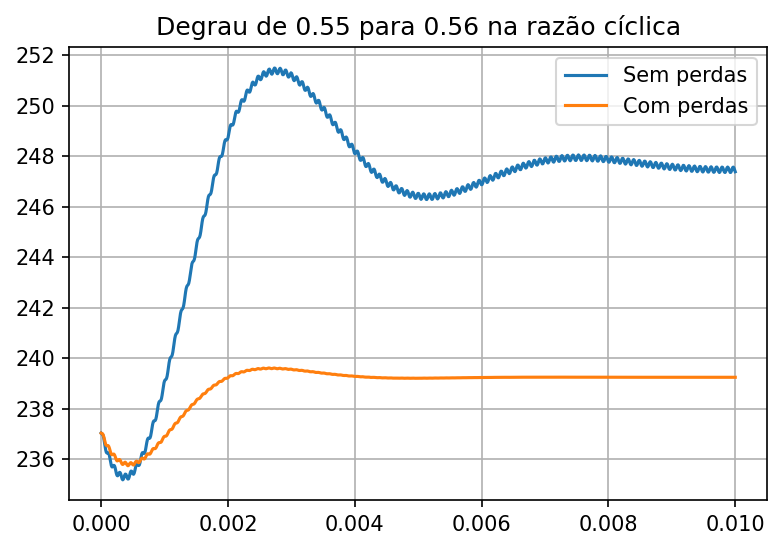

In [59]:
plt.figure(dpi=150)

t=np.linspace(0,10e-3, 1000)

Vi = 48
D = 0.55

_, x = ctl.step_response(Gvd_tf,T=t, X0=0);
_, xp = ctl.step_response(Gvdp_tf,T=t, X0=0);
plt.plot(t,x/100+Vi/(1-D)**2); plt.grid(True);
plt.plot(t,xp/100+Vi/(1-D)**2); plt.grid(True);
plt.title("Degrau de 0.55 para 0.56 na razão cíclica");
plt.legend(["Sem perdas", "Com perdas"]);

<h1 style="color: orange;"> <b> TODO... </b> </h1>

### IV) Simulações para validação

Para fins de comparação, foram simulados os seguintes modelos em Ngspice com captura de esquemático e geração de gráficos do KiCad:

1. Circuito comutado
2. Médio de grandes sinais com circuito equivalente (PWM Switch Modelling)
3. Médio de grandes sinais (equações diferenciais de estados)

Os parâmetros de circuito considerados em todo o desenvolvimento estão listados abaixo:

```
.tran 100ns 30ms uic   ; Simulação transiente até 30ms de passo 100ns com condições iniciais zeradas
```

```
.param Vi=48V          ; Tensão de entrada
.param RSd=1u          ; Resistência série nos diodos
.param Vd=0            ; Queda de tensão nos diodos
.param L1=1000uH
.param L2=100uH
.param C1=2uF
.param C2=20uF
.param R=50
```





Abaixo está ilustrado o modelo comutado:

![comutado](modelo_comutado.png)

Em seguida, o modelo de equações diferenciais de estados:

![ode](modelo_ode.png)


A figura abaixo ilustra o resultado do degrau de $d = 0.55$ para $ d =0.56$ aos $15 ms$ da análise transiente.

Observação: os modelos 2 e 3 se sobrepõem totalmente, impossibilitando distinção mútua.

![step](step_response_spice.png)